In [2]:
import json
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## It may be possible to construct a HMM where hidden state = correct letter, and you transition between states gray -> yellow -> green, also gray -> green possible
### 5 total HMMs, one for each state 
### Each HMM at position i is informed by conditional probability distributions of:
1. yellow in position i given all grays
2. greens in position i given all grays
3. green in position i given yellow in position j
4. and gray given all known grays,  

In [4]:
relfreq = pd.read_csv(r'..\data\processed\relative_letter_frequencies.csv', index_col=0)
relfreq

,0,1,2,3,4
a,0.067495,0.166577,0.112581,0.079914,0.060745
b,0.077754,0.005940,0.025918,0.011609,0.004050
c,0.083423,0.014579,0.025918,0.055076,0.014309
d,0.046166,0.006749,0.032937,0.029158,0.057775
e,0.026728,0.109341,0.072084,0.152268,0.173326
f,0.046976,0.002430,0.008639,0.012959,0.008099
g,0.045086,0.004320,0.031048,0.031317,0.013229
h,0.032937,0.055886,0.006479,0.014039,0.047246
i,0.013229,0.096112,0.100162,0.075324,0.014309
j,0.013769,0.000270,0.002160,0.001890,0.000270


In [5]:
with open(r'..\data\processed\filtered_5letter_words.json', 'r') as file:
    flw = json.load(file)  # flw = five letter words

In [6]:
flw

['which',
 'their',
 'there',
 'would',
 'other',
 'these',
 'about',
 'first',
 'could',
 'after',
 'those',
 'where',
 'being',
 'under',
 'great',
 'state',
 'world',
 'three',
 'while',
 'found',
 'might',
 'still',
 'right',
 'place',
 'every',
 'power',
 'since',
 'given',
 'never',
 'order',
 'water',
 'small',
 'shall',
 'large',
 'point',
 'again',
 'often',
 'among',
 'house',
 'group',
 'think',
 'human',
 'later',
 'until',
 'whole',
 'early',
 'above',
 'value',
 'study',
 'table',
 'taken',
 'times',
 'known',
 'court',
 'young',
 'white',
 'light',
 'least',
 'level',
 'child',
 'death',
 'press',
 'going',
 'party',
 'sense',
 'based',
 'whose',
 'south',
 'total',
 'class',
 'local',
 'along',
 'money',
 'black',
 'force',
 'north',
 'night',
 'short',
 'field',
 'quite',
 'thing',
 'woman',
 'major',
 'third',
 'shown',
 'cause',
 'heart',
 'trade',
 'clear',
 'model',
 'lower',
 'close',
 'blood',
 'story',
 'paper',
 'works',
 'union',
 'river',
 'space',
 'price',


## Relative frequencies gives the probability of each letter appearing at each position

## Construct a transition matrix from Start - 0 --> 1 --> 2 --> 3 --> 4 to 

In [7]:
relfreq['0']

a    0.067495
b    0.077754
c    0.083423
d    0.046166
e    0.026728
f    0.046976
g    0.045086
h    0.032937
i    0.013229
j    0.013769
k    0.013229
l    0.042657
m    0.054266
n    0.020788
o    0.017279
p    0.067495
q    0.008369
r    0.041577
s    0.146598
t    0.068575
u    0.011609
v    0.018898
w    0.028348
x    0.001080
y    0.003780
z    0.001890
Name: 0, dtype: float64

In [8]:
# Start --> 0 is simply the relative frequency of the first column in relfreq df 
s = relfreq['0']

# For each transition between letters, construct a 26x26 matrix of transitions 
alphabet = 'abcdefghijklmnopqrstuvwxyz'
amap = {letter: x for letter, x in zip(alphabet, range(26))}

# transitions matrix t
# previous letter is row index
# current letter is column index 
t = [[[0 for _ in range(26)] for _ in range(26)] for _ in range(4)]

for word in flw:
    for i, (l_prev, l_curr) in enumerate(zip(word[:-1], word[1:])):
        if i == 5:
            break
        t[i][amap[l_prev]][amap[l_curr]] += 1

In [9]:
t_norm = np.array(t) / len(flw)

In [10]:
# calculate likelihoods of all words
likelihoods = []
for word in flw:
    lh = s[word[0]]
    for i, (l_prev, l_curr) in enumerate(zip(word[:-1], word[1:])):
        if i == 5:
            break
        lh *= t_norm[i][amap[l_prev]][amap[l_curr]]
        
    likelihoods.append((word, lh))

## Plotting the log likelihoods of all words is nice, but just because it's likely under all 5-letter words doesn't mean it's likely to be a word that a human is familiar with

## Therefore, normalize the log-likelihood to the Google popularity ranking 

In [11]:
flwfreq = pd.read_csv(r'..\data\processed\flw_with_frequencies.csv').set_index('0').astype('float64')

In [28]:
lhdf = pd.DataFrame(likelihoods).set_index(0)
lhdf.columns = ['likelihood']
lhdf['llh'] = np.log(lhdf['likelihood'])
lhdf = lhdf.join(flwfreq)
lhdf['log_freq'] = np.log(lhdf['freq'])
lhdf['llh_logfreq_norm'] = lhdf['llh'] / lhdf['log_freq']
lhdf

,likelihood,llh,freq,rel_freq,log_freq,llh_logfreq_norm
0,,,,,,
which,3.091614e-10,-21.897158,3.140227e+09,1.000000,21.867561,-1.001353
their,4.757427e-11,-23.768729,2.152980e+09,0.685613,21.490119,-1.106031
there,6.022589e-10,-21.230334,1.623700e+09,0.517065,21.207973,-1.001054
would,3.140741e-11,-24.183977,1.472811e+09,0.469014,21.110439,-1.145593
other,1.603865e-12,-27.158605,1.383186e+09,0.440473,21.047655,-1.290339
...,...,...,...,...,...,...
phare,4.238234e-10,-21.581704,1.007140e+05,0.000032,11.520040,-1.873405
drome,2.651163e-10,-22.050853,1.006860e+05,0.000032,11.519762,-1.914176
chowk,2.131811e-11,-24.571464,1.006430e+05,0.000032,11.519335,-2.133063


Text(0.5, 1.0, 'log-likelihood')

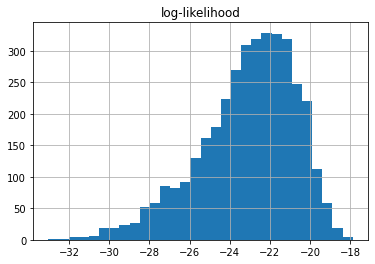

In [29]:
lhdf['llh'].hist(bins=30)
plt.title('log-likelihood')

Text(0.5, 1.0, 'log-likelihood, normalized by log of frequency')

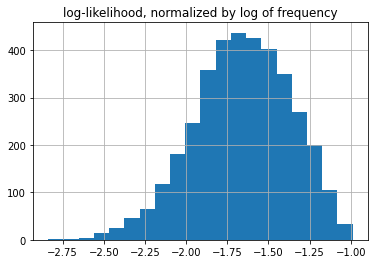

In [30]:
lhdf['llh_logfreq_norm'].hist(bins=20)
plt.title('log-likelihood, normalized by log of frequency')

In [31]:
lhdf

,likelihood,llh,freq,rel_freq,log_freq,llh_logfreq_norm
0,,,,,,
which,3.091614e-10,-21.897158,3.140227e+09,1.000000,21.867561,-1.001353
their,4.757427e-11,-23.768729,2.152980e+09,0.685613,21.490119,-1.106031
there,6.022589e-10,-21.230334,1.623700e+09,0.517065,21.207973,-1.001054
would,3.140741e-11,-24.183977,1.472811e+09,0.469014,21.110439,-1.145593
other,1.603865e-12,-27.158605,1.383186e+09,0.440473,21.047655,-1.290339
...,...,...,...,...,...,...
phare,4.238234e-10,-21.581704,1.007140e+05,0.000032,11.520040,-1.873405
drome,2.651163e-10,-22.050853,1.006860e+05,0.000032,11.519762,-1.914176
chowk,2.131811e-11,-24.571464,1.006430e+05,0.000032,11.519335,-2.133063


In [32]:
lhdf = lhdf.sort_values('llh', ascending=False)
lhdf['likelihood_rank'] = range(lhdf.shape[0])
lhdf

,likelihood,llh,freq,rel_freq,log_freq,llh_logfreq_norm,likelihood_rank
0,,,,,,,
sheer,1.729550e-08,-17.872820,9225539.0,0.002938,16.037486,-1.114440,0
carer,1.613908e-08,-17.942022,330286.0,0.000105,12.707714,-1.411900,1
cater,1.370978e-08,-18.105156,1523233.0,0.000485,14.236346,-1.271756,2
borer,1.217471e-08,-18.223905,655503.0,0.000209,13.393158,-1.360688,3
crier,1.171228e-08,-18.262628,373091.0,0.000119,12.829578,-1.423478,4
...,...,...,...,...,...,...,...
ephod,1.703968e-14,-31.703231,122918.0,0.000039,11.719273,-2.705222,3699
igloo,1.616475e-14,-31.755943,216660.0,0.000069,12.286085,-2.584708,3700
itchy,8.222939e-15,-32.431849,367617.0,0.000117,12.814797,-2.530813,3701


In [52]:
lhdf = lhdf.sort_values('freq', ascending=False)
lhdf['freq_rank'] = range(lhdf.shape[0])
lhdf

,likelihood,llh,freq,rel_freq,log_freq,llh_logfreq_norm,likelihood_rank,likelihood_norm_rank,llh_freq_norm,freq_rank
0,,,,,,,,,,
which,3.091614e-10,-21.897158,3.140227e+09,1.000000,21.867561,-1.001353,1289,5,-21.897158,0
their,4.757427e-11,-23.768729,2.152980e+09,0.685613,21.490119,-1.106031,2449,54,-34.667848,1
there,6.022589e-10,-21.230334,1.623700e+09,0.517065,21.207973,-1.001054,868,4,-41.059342,2
would,3.140741e-11,-24.183977,1.472811e+09,0.469014,21.110439,-1.145593,2649,99,-51.563416,3
other,1.603865e-12,-27.158605,1.383186e+09,0.440473,21.047655,-1.290339,3442,397,-61.657785,4
...,...,...,...,...,...,...,...,...,...,...
phare,4.238234e-10,-21.581704,1.007140e+05,0.000032,11.520040,-1.873405,1081,2852,-672909.842150,3699
drome,2.651163e-10,-22.050853,1.006860e+05,0.000032,11.519762,-1.914176,1401,3003,-687728.922162,3700
chowk,2.131811e-11,-24.571464,1.006430e+05,0.000032,11.519335,-2.133063,2809,3485,-766669.971290,3701


In [33]:
lhdf = lhdf.sort_values('llh_logfreq_norm', ascending=False)
lhdf['likelihood_norm_rank'] = range(lhdf.shape[0])
lhdf

,likelihood,llh,freq,rel_freq,log_freq,llh_logfreq_norm,likelihood_rank,likelihood_norm_rank
0,,,,,,,,
these,9.661236e-10,-20.757729,1.305787e+09,0.415826,20.990072,-0.988931,573,0
state,2.182214e-09,-19.942926,5.533860e+08,0.176225,20.131566,-0.990630,223,1
later,4.252075e-09,-19.275859,2.694206e+08,0.085797,19.411784,-0.992998,62,2
being,1.596078e-09,-20.255717,6.161945e+08,0.196226,20.239073,-1.000822,344,3
there,6.022589e-10,-21.230334,1.623700e+09,0.517065,21.207973,-1.001054,868,4
...,...,...,...,...,...,...,...,...
oxbow,3.469899e-14,-30.992066,1.524310e+05,0.000049,11.934467,-2.596854,3691,3699
octyl,6.196249e-14,-30.412247,1.078680e+05,0.000034,11.588664,-2.624310,3681,3700
xylol,1.900183e-14,-31.594241,1.487650e+05,0.000047,11.910123,-2.652722,3698,3701


Text(0, 0.5, 'Likelihood rank')

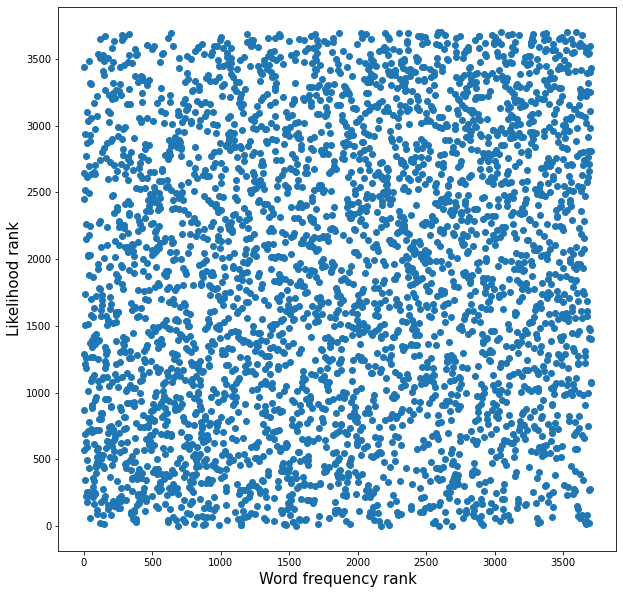

In [53]:
plt.scatter(lhdf['freq_rank'], lhdf['likelihood_rank'])
plt.gcf().set_size_inches((10, 10))
plt.xlabel('Word frequency rank', fontsize=15)
plt.ylabel('Likelihood rank', fontsize=15)

Text(0, 0.5, 'log-likelihood')

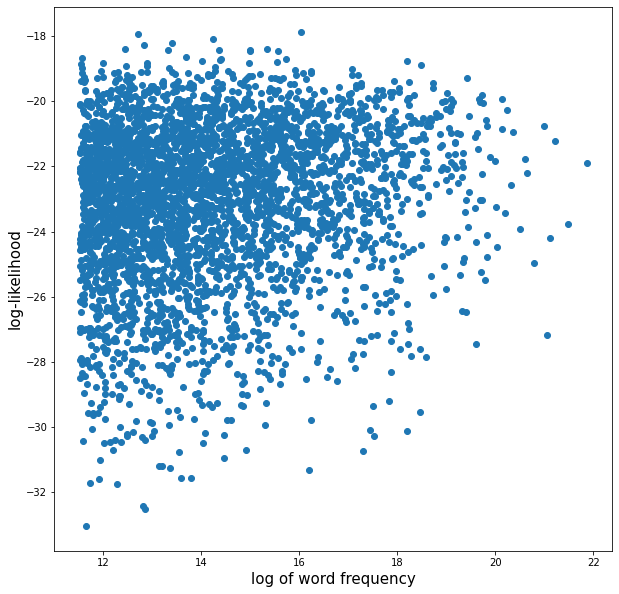

In [51]:
plt.scatter(lhdf['log_freq'], lhdf['llh'])
plt.gcf().set_size_inches((10, 10))
plt.xlabel('log of word frequency', fontsize=15)
plt.ylabel('log-likelihood', fontsize=15)

Text(0, 0.5, 'rank order likelihood, normalized by word commonness')

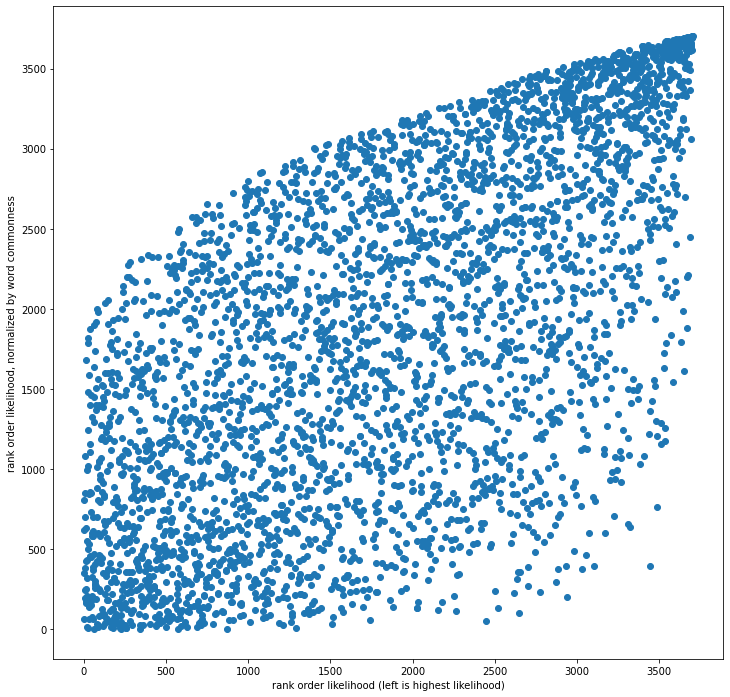

In [34]:
plt.scatter(lhdf['likelihood_rank'], lhdf['likelihood_norm_rank'])
plt.gcf().set_size_inches((12, 12))
plt.xlabel('rank order likelihood (left is highest likelihood)')
plt.ylabel('rank order likelihood, normalized by word commonness')

Text(0, 0.5, 'Log-likelihood, normalized by log-frequency')

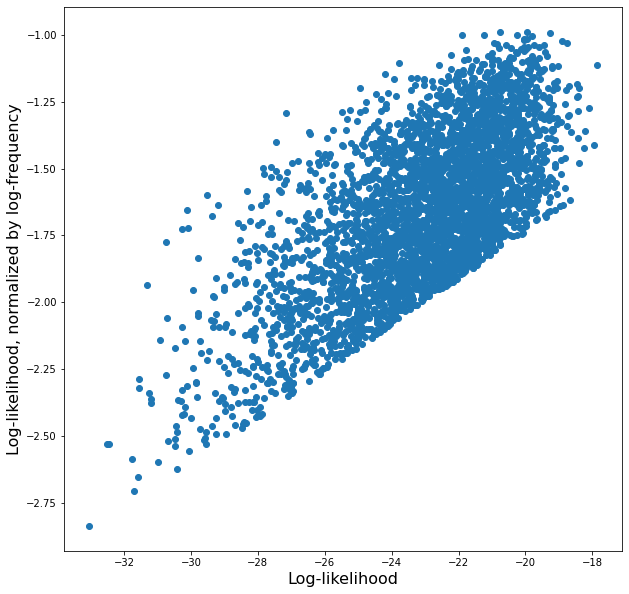

In [55]:
plt.scatter(lhdf['llh'], lhdf['llh_logfreq_norm'])
plt.gcf().set_size_inches((10, 10))
plt.xlabel('Log-likelihood', fontsize=16)
plt.ylabel('Log-likelihood, normalized by log-frequency', fontsize=16)

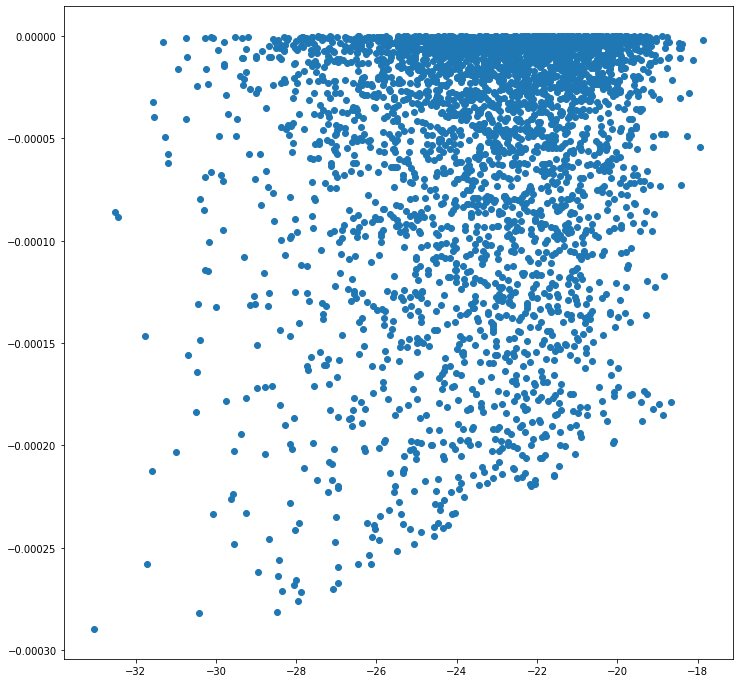

In [36]:
plt.scatter(lhdf['llh'], (lhdf['llh'] / lhdf['freq']))
plt.gcf().set_size_inches((12, 12))

In [37]:
lhdf['llh'] = np.log(lhdf['likelihood'])
lhdf['llh_freq_norm'] = lhdf['llh'] / lhdf['rel_freq']

<AxesSubplot:>

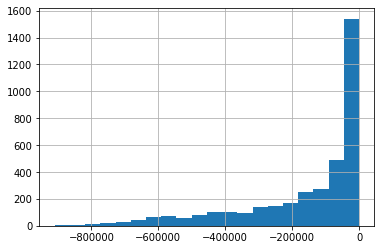

In [38]:
lhdf['llh_freq_norm'].hist(bins=20)

In [39]:
lhdf

,likelihood,llh,freq,rel_freq,log_freq,llh_logfreq_norm,likelihood_rank,likelihood_norm_rank,llh_freq_norm
0,,,,,,,,,
these,9.661236e-10,-20.757729,1.305787e+09,0.415826,20.990072,-0.988931,573,0,-49.919286
state,2.182214e-09,-19.942926,5.533860e+08,0.176225,20.131566,-0.990630,223,1,-113.167489
later,4.252075e-09,-19.275859,2.694206e+08,0.085797,19.411784,-0.992998,62,2,-224.669392
being,1.596078e-09,-20.255717,6.161945e+08,0.196226,20.239073,-1.000822,344,3,-103.226394
there,6.022589e-10,-21.230334,1.623700e+09,0.517065,21.207973,-1.001054,868,4,-41.059342
...,...,...,...,...,...,...,...,...,...
oxbow,3.469899e-14,-30.992066,1.524310e+05,0.000049,11.934467,-2.596854,3691,3699,-638466.647018
octyl,6.196249e-14,-30.412247,1.078680e+05,0.000034,11.588664,-2.624310,3681,3700,-885353.839902
xylol,1.900183e-14,-31.594241,1.487650e+05,0.000047,11.910123,-2.652722,3698,3701,-666911.415286


In [40]:
lhdf.values / flwfreq.values

ValueError: operands could not be broadcast together with shapes (3704,9) (3704,2) 

In [41]:
t01 = pd.DataFrame(t[0]) / len(flw) + 0.000001
t12 = pd.DataFrame(t[1]) / len(flw) + 0.000001
t23 = pd.DataFrame(t[2]) / len(flw) + 0.000001
t34 = pd.DataFrame(t[3]) / len(flw) + 0.000001

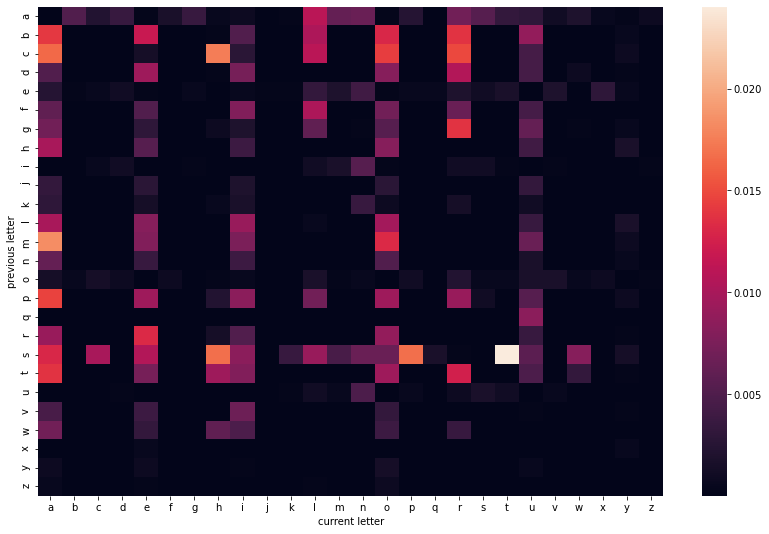

In [42]:
sns.heatmap(t01)
plt.gcf().set_size_inches((14, 9))
plt.xlabel('current letter')
plt.ylabel('previous letter')
plt.yticks(ticks=[x + 0.5 for x in range(26)], labels=[letter for letter in alphabet])
plt.xticks(ticks=[x + 0.5 for x in range(26)], labels=[letter for letter in alphabet]);

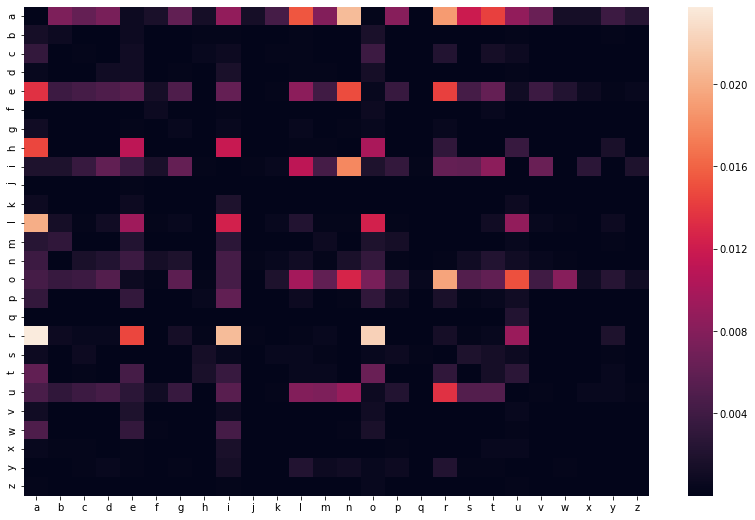

In [41]:
sns.heatmap(t12)
plt.gcf().set_size_inches((14, 9))
plt.xlabel('current letter')
plt.ylabel('previous letter')
plt.yticks(ticks=[x + 0.5 for x in range(26)], labels=[letter for letter in alphabet]);
plt.xticks(ticks=[x + 0.5 for x in range(26)], labels=[letter for letter in alphabet]);

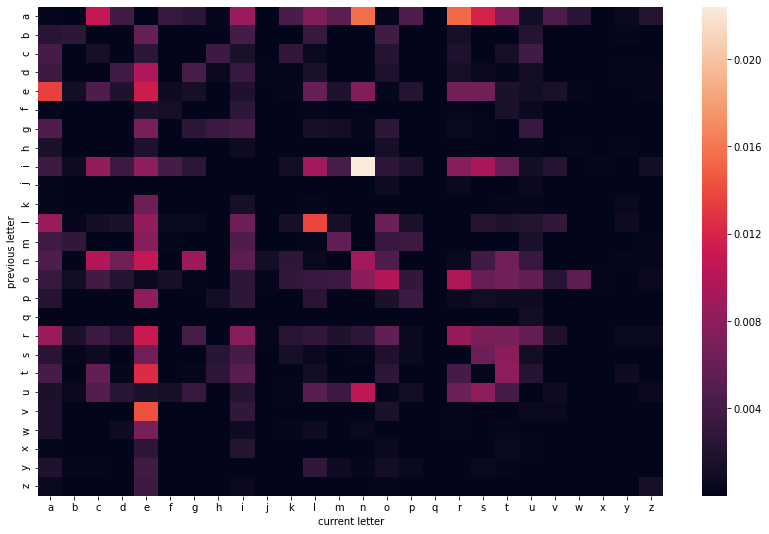

In [44]:
sns.heatmap(t23)
plt.gcf().set_size_inches((14, 9))
plt.xlabel('current letter')
plt.ylabel('previous letter')
plt.yticks(ticks=[x + 0.5 for x in range(26)], labels=[letter for letter in alphabet]);
plt.xticks(ticks=[x + 0.5 for x in range(26)], labels=[letter for letter in alphabet]);

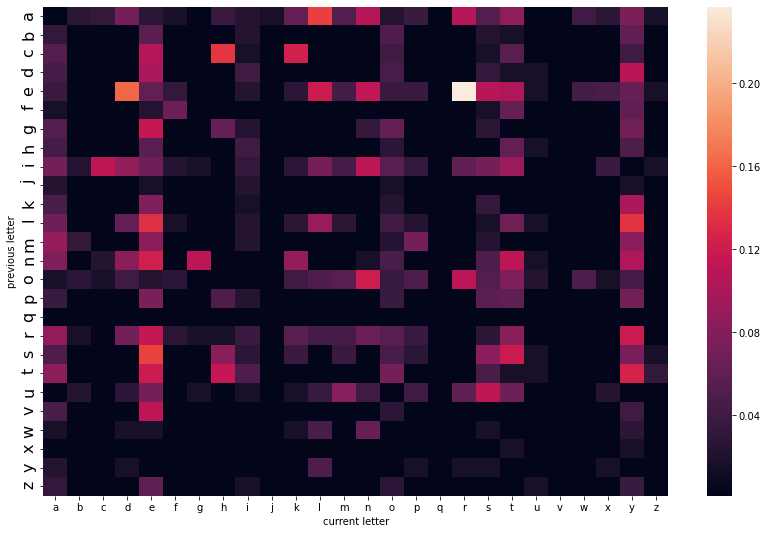

In [50]:
sns.heatmap(np.sqrt(t34))
plt.gcf().set_size_inches((14, 9))
plt.xlabel('current letter')
plt.ylabel('previous letter')
plt.yticks(ticks=[x + 0.5 for x in range(26)], labels=[letter for letter in alphabet], fontsize=16);
plt.xticks(ticks=[x + 0.5 for x in range(26)], labels=[letter for letter in alphabet]);

In [43]:
def make_heatmap(df):
    sns.heatmap(df, cbar_kws={'label': 'colorbar title'})
    plt.gcf().set_size_inches((11, 7))
    plt.xlabel('current letter', fontsize=18)
    plt.ylabel('previous letter', fontsize=18)
    plt.yticks(ticks=[x + 0.5 for x in range(26)], labels=[letter for letter in alphabet], fontsize=16);
    plt.xticks(ticks=[x + 0.5 for x in range(26)], labels=[letter for letter in alphabet], fontsize=16);

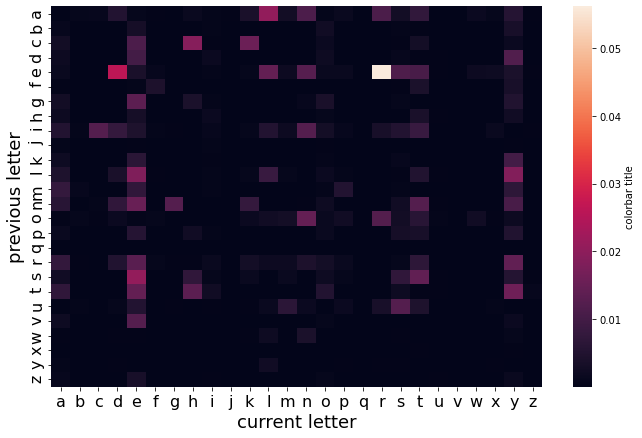

In [46]:
make_heatmap(t34)

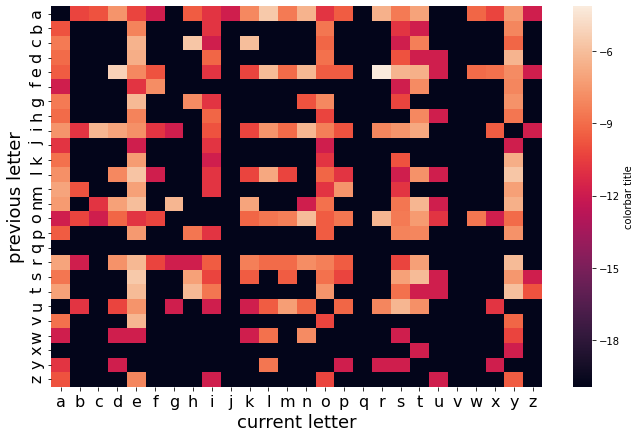

In [45]:
make_heatmap(np.log2(t34))

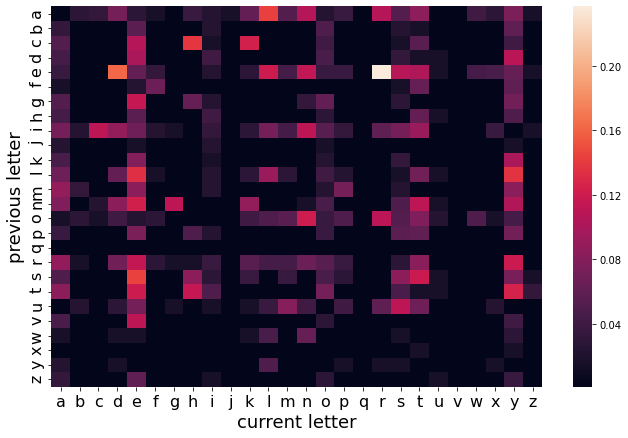

In [72]:
make_heatmap(np.sqrt(t34))
